In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
from random import randint
import glob
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, ReLU,concatenate,Dropout, BatchNormalization,MaxPooling2D,Conv2DTranspose, UpSampling2D

In [2]:
def raster2rgb(img_data):
	bands_count = img_data.RasterCount
	
	r = img_data.GetRasterBand(4)
	g = img_data.GetRasterBand(3)
	b = img_data.GetRasterBand(2)
	
	r1 = r.ReadAsArray()
	g1 = g.ReadAsArray()
	b1 = b.ReadAsArray()
	
	img = np.dstack((r1,g1,b1))
	
	out = np.zeros_like(img).astype(np.float32)
	n = img.shape[2]
	for i in range(n):
		a, b = 0, 1
		c = np.percentile(img[:,:,i],2)
		d = np.percentile(img[:,:,i],98)
		t = a +(img[:,:,i]-c)*(b-a)/(d-c)
		t[t<a] = a
		t[t>b] = b
		out[:,:,i] = t
		
	return out


In [6]:
def images_split(total_images_path):
    total_images = []
    for file in glob.iglob(total_images_path+'**/*.tif',recursive=True):
        image = gdal.Open(file, gdal.GA_ReadOnly)
        output_image = raster2rgb(image)
        total_images.append(output_image)
    
    total_images_count = len(total_images)
    total_images = np.asarray(total_images)
    n_train = 4506
    n_valid = 1100
    n_test = 80
    X_train = []
    X_valid = []
    X_test = []

    for i in range(0,400):
        X_train.append(total_images[i])
	
    for i in range(400,500):
        X_valid.append(total_images[i])
	
    for i in range(500,530):
        X_test.append(total_images[i])
    
    X_train = np.asarray(X_train)
    X_valid = np.asarray(X_valid)
    X_test = np.asarray(X_test)
	
    return X_train,X_valid,X_test
    

In [7]:
total_images_path= 'D:/vision_impulse/images/'
X_train, X_valid, X_test = images_split(total_images_path)

In [12]:
print(X_train.shape)
print(X_valid.shape[0])
print(X_test.shape[0])


(400, 64, 64, 3)
100
30


In [7]:
def raster2label(img_data):
    bands_count = img_data.RasterCount
    gray= img_data.GetRasterBand(1)
    gray1 = gray.ReadAsArray()
    label = gray1.reshape((64,64,1))
    
    return label

In [30]:
def labels_split(total_labels_path):
    total_labels = []
    for file in glob.iglob(total_labels_path+'**/*.tif',recursive=True):
        label = gdal.Open(file, gdal.GA_ReadOnly)
        g = label.GetRasterBand(1)
        g = label.ReadAsArray()
        g = g.reshape((64,64,1))
        #print(g)        
        #output_label = raster2label(label)

        total_labels.append(g)
    
    total_label_count = len(total_labels)
    total_labels = np.asarray(total_labels)
    n_train = 4506
    n_valid = 1100
    n_test = 80
    y_train = []
    y_valid = []
    y_test = []

    for i in range(0,400):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_train.append(l)
	
    for i in range(400,500):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_valid.append(l)
	
    for i in range(500,530):
        l = total_labels[i]
        l = tf.keras.utils.to_categorical(l,3)
        y_test.append(l)
    
    y_train = np.asarray(y_train)
    y_valid = np.asarray(y_valid)
    y_test = np.asarray(y_test)
	
    return y_train,y_valid,y_test


In [31]:
total_labels_path = 'D:/vision_data_duplicate/vision_impulse/labels/'
y_train, y_valid, y_test = labels_split(total_labels_path)

In [34]:
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(400, 64, 64, 3)
(30, 64, 64, 3)
(100, 64, 64, 3)


In [39]:
def visualize(viz_list):
    plt.figure(figsize=(15,15))
    title = ['Input_image', 'Input_mask', 'predicted_mask']
    
    for i in range(len(viz_list)):
        plt.subplot(1,len(viz_list), i+1)
        plt.title(title[i])
        plt.imshow(viz_list[i])
        plt.axis('off')
    plt.show()
    

27


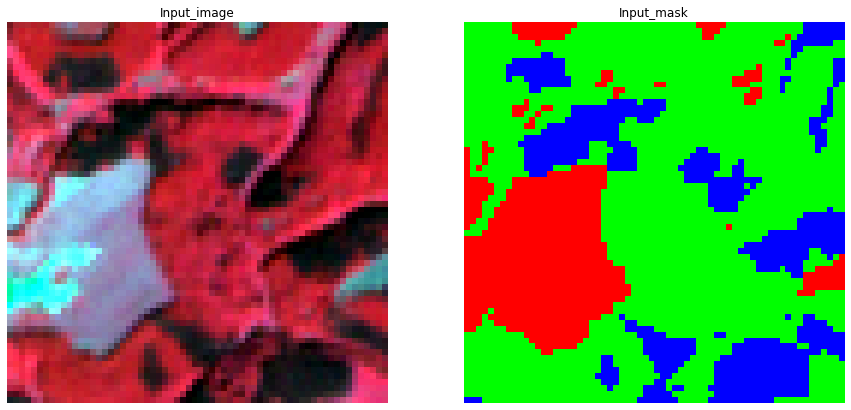

In [40]:

rand_num = randint(0,X_train.shape[0])

print(rand_num)

visualize([X_train[rand_num],y_train[rand_num]])

In [60]:
def conv_block(input_tensor, num_filters,kernel_size):
    c = Conv2D(filters= num_filters,kernel_size=kernel_size,kernel_initializer='he_normal',strides=(1,1),padding='same')(input_tensor)
    c = ReLU()(c)
    return c


def U_Net(input_lr,num_filters=64,kernel_size=3,dropout_rate=0.1):
    
    #block1
    c1 = conv_block(input_lr,num_filters*1,kernel_size=kernel_size)
    c2 = conv_block(c1,num_filters*1,kernel_size=kernel_size)
    p1 = MaxPooling2D(pool_size=(2,2))(c2)
    
    #block2
    c3 = conv_block(p1,num_filters*2,kernel_size=kernel_size)
    c4 = conv_block(c3,num_filters*2,kernel_size=kernel_size)
    p2 = MaxPooling2D(pool_size=(2,2))(c4)
    
    #block3
    c5 = conv_block(p2,num_filters*4,kernel_size=kernel_size)
    c5 = Dropout(dropout_rate)(c5)
    c6 = conv_block(c5,num_filters*4,kernel_size=kernel_size)
    p3 = MaxPooling2D(pool_size=(2,2))(c6)
    
    #block4
    c7 = conv_block(p3,num_filters*8,kernel_size=kernel_size)
    c7 = Dropout(dropout_rate)(c7)
    c8 = conv_block(c7,num_filters*8,kernel_size=kernel_size)
    p4 = MaxPooling2D(pool_size=(2,2))(c8)
    
    #block5(bottleneck)
    c9 = conv_block(p4,num_filters*16,kernel_size = kernel_size)
    c10 = conv_block(c9,num_filters*16,kernel_size=kernel_size)
    
    #expanding block (block6)
    u6 = Conv2DTranspose(filters=num_filters*8,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c10)
    u6 = concatenate([u6,c8])
    c11 = conv_block(u6,num_filters*8,kernel_size=kernel_size)
    c11 = Dropout(dropout_rate)(c11)
    c12 = conv_block(c11,num_filters*8,kernel_size=kernel_size)
    
    #block7
    u7 = Conv2DTranspose(filters=num_filters*4,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c12)
    u7 = concatenate([u7,c6])
    c13 = conv_block(u7,num_filters*4,kernel_size=kernel_size)
    c13 = Dropout(dropout_rate)(c13)
    c14 = conv_block(c13,num_filters*4,kernel_size=kernel_size)
    
    #block8
    u8 = Conv2DTranspose(filters=num_filters*2,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c14)
    u8 = concatenate([u8,c4])
    c15 = conv_block(u8,num_filters*2,kernel_size=kernel_size)
    c15 = Dropout(dropout_rate)(c15)
    c16 = conv_block(c15,num_filters*2,kernel_size=kernel_size)
    
    #block9
    u9 = Conv2DTranspose(filters= num_filters*1,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c16)
    u9 = concatenate([u9,c2])
    c17 = conv_block(u9,num_filters*1,kernel_size=kernel_size)
    c18 = conv_block(c17,num_filters*1,kernel_size=kernel_size)
    
    output = Conv2D(filters=3,kernel_size=(1,1),strides=(1,1),padding='same',activation='softmax',kernel_initializer='he_normal')(c18)
    
    model = Model(inputs=[input_lr],outputs=[output])
    
    return model

In [70]:
input_lr = Input((X_train.shape[1],X_train.shape[2],X_train.shape[3]),name='input_lr')
model = U_Net(input_lr)
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lr (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 64, 64, 64)   1792        input_lr[0][0]                   
__________________________________________________________________________________________________
re_lu_54 (ReLU)                 (None, 64, 64, 64)   0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 64, 64, 64)   36928       re_lu_54[0][0]                   
____________________________________________________________________________________________

In [80]:
model.fit(X_train,y_train,batch_size=16,validation_data=(X_valid,y_valid),epochs=100)

Epoch 1/100
25/25 [==============================] - 10s 395ms/step - loss: 0.1172 - accuracy: 0.9534 - val_loss: 0.3315 - val_accuracy: 0.8992
Epoch 2/100
25/25 [==============================] - 10s 396ms/step - loss: 0.1128 - accuracy: 0.9552 - val_loss: 0.3222 - val_accuracy: 0.9030
Epoch 3/100
25/25 [==============================] - 10s 396ms/step - loss: 0.1106 - accuracy: 0.9558 - val_loss: 0.3444 - val_accuracy: 0.8984
Epoch 4/100
25/25 [==============================] - 10s 395ms/step - loss: 0.1047 - accuracy: 0.9582 - val_loss: 0.3250 - val_accuracy: 0.9036
Epoch 5/100
25/25 [==============================] - 10s 395ms/step - loss: 0.1006 - accuracy: 0.9597 - val_loss: 0.3283 - val_accuracy: 0.9018
Epoch 6/100
25/25 [==============================] - 10s 395ms/step - loss: 0.0973 - accuracy: 0.9609 - val_loss: 0.3124 - val_accuracy: 0.9056
Epoch 7/100
25/25 [==============================] - 10s 396ms/step - loss: 0.0950 - accuracy: 0.9616 - val_loss: 0.2922 - val_accuracy:

25/25 [==============================] - 10s 395ms/step - loss: 0.0547 - accuracy: 0.9773 - val_loss: 0.4582 - val_accuracy: 0.9018
Epoch 58/100
25/25 [==============================] - 10s 395ms/step - loss: 0.0529 - accuracy: 0.9780 - val_loss: 0.4667 - val_accuracy: 0.9019
Epoch 59/100
25/25 [==============================] - 10s 395ms/step - loss: 0.0520 - accuracy: 0.9784 - val_loss: 0.4675 - val_accuracy: 0.9016
Epoch 60/100
25/25 [==============================] - 10s 395ms/step - loss: 0.0509 - accuracy: 0.9789 - val_loss: 0.4532 - val_accuracy: 0.9018
Epoch 61/100
25/25 [==============================] - 10s 395ms/step - loss: 0.0505 - accuracy: 0.9790 - val_loss: 0.4514 - val_accuracy: 0.9026
Epoch 62/100
25/25 [==============================] - 10s 395ms/step - loss: 0.0516 - accuracy: 0.9786 - val_loss: 0.4458 - val_accuracy: 0.9039
Epoch 63/100
25/25 [==============================] - 10s 396ms/step - loss: 0.0607 - accuracy: 0.9747 - val_loss: 0.3801 - val_accuracy: 0.908

In [81]:
y_pred = model.predict(X_test)

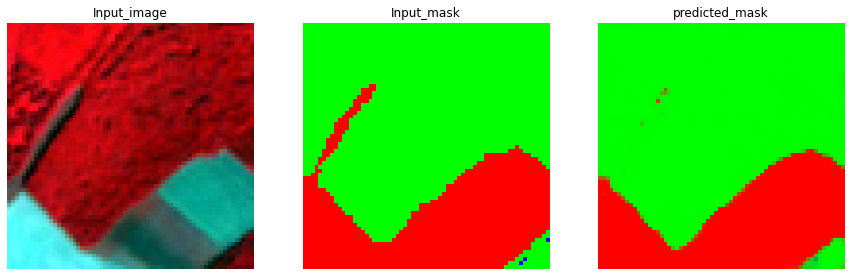

In [83]:
visualize([X_test[0],y_test[0],y_pred[0]])

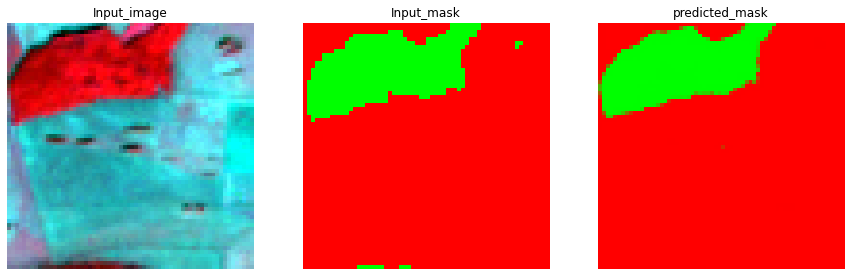

In [84]:
visualize([X_test[12],y_test[12],y_pred[12]])

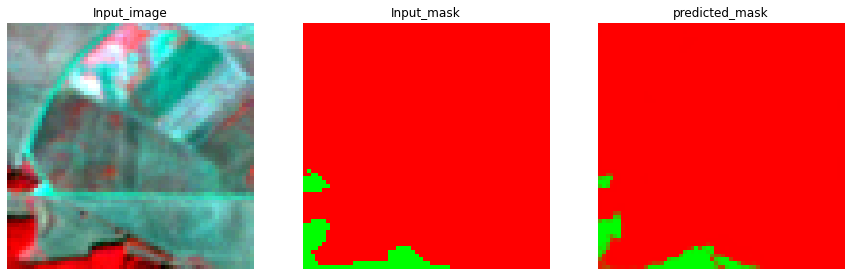

In [85]:
visualize([X_test[22],y_test[22],y_pred[22]])

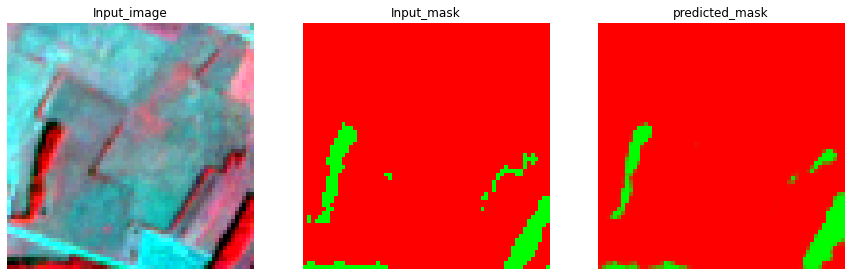

In [86]:
visualize([X_test[26],y_test[26],y_pred[26]])